In [230]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats
import statsmodels.api as sm

In [231]:
parser = lambda date: pd.to_datetime(date,format='%m/%d/%y')
Stocks = pd.read_csv("D:\SIMON\QUANT FIN PYTHON\Final Project\dataset\Return2.csv",index_col=0, \
                         parse_dates=True,date_parser=parser,header=0,na_values=-99.99)
Stocks['RF']=Stocks['RF']/100
#this is randomly selected stock data from different industries 
Stocks=(Stocks.drop('RF',axis=1)).subtract(Stocks['RF'],axis='index')
Stock2=Stocks['2008-06':]

In [232]:
# in long period, the time series change tend to be more fluctuated, and 
#beside that, some calculation loop takes python forever to run, so we only use 5 years of data
Stock3=Stocks['2013-06':]

In [233]:
def hurst(df):
    H=[]
    #input daily
    for X in df.columns:
        X = np.array(df[X])
    
    #N is the maxmum slice size of array X
        N = X.size
    
        T = np.arange(1, N + 1)
        Y = np.cumsum(X)
    
    #compute the mean of different time period slices
        Ave_T = Y / T

    #R_T is maximum range of the time period slices
        R_T = np.zeros(N)
    #S_T is standard deviation of time period slices
        S_T = np.zeros(N)
    
    #compute R_T and S_T of different time period slices of array X
        for i in range(N):
            S_T[i] = np.std(X[:i + 1])
            Z_T = Y - T * Ave_T[i]
            R_T[i] = np.ptp(Z_T[:i + 1])
        
    #calculate R/S
        R_S = R_T / S_T
    
    #lg(R/S) as dependent variable Y
        R_S = np.log(R_S)[1:]
    
    #lgt as explain variable X
        n = np.log(T)[1:]
        A = np.column_stack((n, np.ones(n.size)))
    
    #run a regression of y to x, the slope is the Hurst exponent
        [m, c] = np.linalg.lstsq(A, R_S)[0]
        H.append(m)
    return H
    

In [234]:
#here we define a function to rolling
def rolling_hurst(df, window, lag=None):
    roll_hurst = pd.DataFrame(np.nan, index=df.index,columns=df.columns)
    for i in range(1, len(df)+1):
        sub_df = df.iloc[max(i-window, 0):i,:] 
        idx = sub_df.index[-1]
        if len(sub_df) >= window:
            roll_hurst.ix[idx] = hurst(sub_df)
    if lag:
        roll_hurst = roll_hurst.shift(periods = lag)
    return roll_hurst

In [235]:
df=rolling_hurst(Stock3,12)
dfT = df.T
dfN = dfT.unstack(level = 1)
dfN = pd.DataFrame(dfN)
dfN.to_csv('D:\SIMON\QUANT FIN PYTHON\Final Project\silly.csv')
data=pd.read_csv('D:\SIMON\QUANT FIN PYTHON\Final Project\silly.csv',index_col=0, \
                         parse_dates=True,header=0)
data.columns=['Stock','Hurst']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [236]:
#here the beta is meansure of relationship of cumulative returns across time.
#positive beta means stock cumulative returns increase across time
def beta(df):
    A=[]
    for x in df.columns:
        regindex = np.polyfit((1+df[x]).cumprod(),np.arange(len(df[x])),1)
        A.append(regindex[0])
    return A

In [237]:
#rolling beta of different tim
def rolling_beta(df, window, lag=None):
    roll_beta = pd.DataFrame(np.nan, index=df.index,columns=df.columns)
    for i in range(1, len(df)+1):
        sub_df = df.iloc[max(i-window, 0):i,:] 
        idx = sub_df.index[-1]
        if len(sub_df) >= window:
            roll_beta.ix[idx] = beta(sub_df)
    if lag:
        roll_beta = roll_beta.shift(periods = lag)
    return roll_beta

In [238]:
b=rolling_beta(Stock3,12)
bT = b.T
bN = bT.unstack(level = 1)
bN = pd.DataFrame(bN)
bN.to_csv('D:\\SIMON\\QUANT FIN PYTHON\\Final Project\\b.csv')
bdata=pd.read_csv('D:\\SIMON\\QUANT FIN PYTHON\\Final Project\\b.csv',index_col=0, \
                         parse_dates=True,header=0)
bdata.columns=['Stock','Beta']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [239]:
data['Beta']=bdata['Beta']
data=data.dropna()#to drop all nan generated from rolling

In [240]:
#the hurst exponent alone is not enough to predict the return of certain stocks, it also relies on Beta we construct before
#as we discussed in report, when hurst>0.5 and beta >0\hurst<0.5 and beta<0, we can long the stocks. 
#Otherwise we short, so here we constructed a signal value to measure the strength of hurst exponent in different situations
data['Signal']=data['Beta']
for i in range(0,len(data.index)):
    if (data['Beta'][i] > 0) & (data['Hurst'][i]>0.5)|((data['Beta'][i]< 0) & (data['Hurst'][i]<0.5)):
        data["Signal"][i]=abs(data["Hurst"][i]-0.5)
    elif (data['Beta'][i]> 0) & (data['Hurst'][i]<0.5)|((data['Beta'][i]< 0) & (data['Hurst'][i]>0.5)):
        data["Signal"][i]=-abs(data["Hurst"][i]-0.5)
data.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Stock,Hurst,Beta,Signal
Date,,,,
2014-05-01,DTE,0.680206,39.178866,0.180206
2014-05-01,PPL,0.866649,43.631821,0.366649
2014-05-01,XEL,0.586803,44.653975,0.086803
2014-05-01,D,0.402255,32.642692,-0.097745
2014-05-01,ETR,0.705290,27.792140,0.205290


In [241]:
#we label stock of 10 levels using the signal
data['group']=data.groupby(['Date'])['Signal'].transform(lambda x: pd.qcut(x, 10, labels=False,duplicates='drop'))
data[['group']]='hurst'+data[['group']].astype(int).astype(str)

In [242]:
StT = Stock2.T
StN = StT.unstack(level = 1)
StN = pd.DataFrame(StN)
StN.to_csv('D:\SIMON\QUANT FIN PYTHON\Final Project\stock.csv')
ret=pd.read_csv('D:\SIMON\QUANT FIN PYTHON\Final Project\stock.csv',index_col=0, \
                         parse_dates=True,header=0)
ret.columns=['Stock','ret']
ret=ret['2014-05':]

In [243]:
#merge the data of return with the signal and group
data1 = pd.merge(data, ret, how = 'outer', on=['Date','Stock'])
#here we use simple equal weight to demonstrate
data1['weight']=1/10

In [244]:
def wavg(group, ret_name, weight_name):
    d = group[ret_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan
    
Wret = data1.groupby(['Date','group']).apply(wavg, 'ret','weight')
Wret = Wret.reset_index().rename(columns={0:'Wret'})# give a name to the new time-seires
Wret=Wret.set_index(['Date','group']) # set indexes
Wret.head(20)

Wret
Date       group           
2014-05-01 hurst0 -0.010161
           hurst1 -0.006424
           hurst2 -0.002329
           hurst3  0.024634
           hurst4 -0.025490
           hurst5  0.004415
           hurst6  0.008320
           hurst7 -0.013384
           hurst8  0.018728
           hurst9  0.030780
2014-06-01 hurst0  0.032584
           hurst1  0.067014
           hurst2  0.061345
           hurst3 -0.006013
           hurst4  0.011612
           hurst5  0.010092
           hurst6  0.006289
           hurst7  0.037358
           hurst8  0.034968
           hurst9  0.069845

In [245]:
Wret=Wret.unstack(level=-1)
Wret=Wret.Wret# remove the higher index
Wret.head()

group,hurst0,hurst1,hurst2,hurst3,hurst4,hurst5,hurst6,hurst7,hurst8,hurst9
Date,,,,,,,,,,
2014-05-01,-0.010161,-0.006424,-0.002329,0.024634,-0.025490,0.004415,0.008320,-0.013384,0.018728,0.030780
2014-06-01,0.032584,0.067014,0.061345,-0.006013,0.011612,0.010092,0.006289,0.037358,0.034968,0.069845
2014-07-01,-0.023851,0.006087,-0.039756,-0.032857,-0.046774,-0.033902,-0.039512,-0.052370,-0.043155,-0.030580
2014-08-01,0.020745,0.047564,0.034312,0.028966,0.029652,0.029707,0.040892,0.051658,0.047865,0.031605
2014-09-01,-0.002551,-0.005221,-0.111263,-0.033670,-0.027069,-0.002560,-0.045750,-0.026995,-0.029439,-0.069310


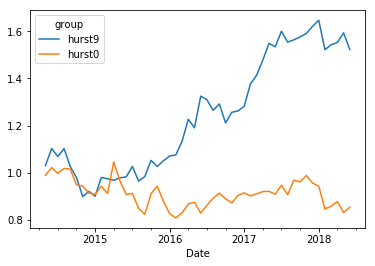

In [246]:
#plot to see the differece in cumulative returns of highest level signal portfolios and lowest level signal portfolios
#the difference become large overtime, the strategy is somewhat okay.
(1+Wret[['hurst9','hurst0']]).cumprod().plot()

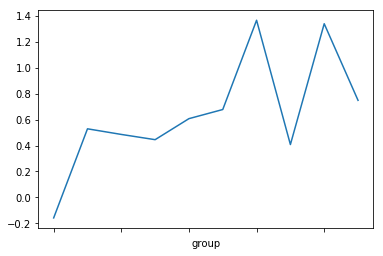

In [247]:
#plot annual Sharpe Ratio across portfolios, a tendency to increase when group level increases
(Wret.mean()/Wret.std()*12**0.5).plot()

In [267]:
#Next we are going to use CAPM and FF3 model to evaluate the strategies performance
CAPM=pd.DataFrame(Wret.mean())
CAPM.columns=['Avgreturns']

In [249]:
parser = lambda date: pd.to_datetime(date,format='%Y%m')
factor=pd.read_csv('D:\SIMON\QUANT FIN PYTHON\Final Project\F.csv',index_col=0,parse_dates=True,date_parser=parser)
factor=factor/100
factor=factor['2014-05':]
factor

,Mkt-RF,SMB,HML,RMW,CMA,RF
2014-05-01,0.0206,-0.0190,-0.0027,0.0013,-0.0106,0.0000
2014-06-01,0.0261,0.0309,-0.0074,-0.0201,-0.0194,0.0000
2014-07-01,-0.0204,-0.0426,0.0001,0.0095,0.0048,0.0000
2014-08-01,0.0424,0.0028,-0.0058,-0.0064,-0.0068,0.0000
2014-09-01,-0.0197,-0.0379,-0.0123,0.0118,-0.0053,0.0000
2014-10-01,0.0252,0.0378,-0.0168,-0.0047,-0.0014,0.0000
2014-11-01,0.0255,-0.0229,-0.0299,0.0128,0.0020,0.0000
2014-12-01,-0.0006,0.0287,0.0206,-0.0117,0.0088,0.0000
2015-01-01,-0.0311,-0.0087,-0.0347,0.0171,-0.0171,0.0000
2015-02-01,0.0613,0.0021,-0.0179,-0.0111,-0.0171,0.0000


In [271]:
for portfolios in CAPM.index:
    y=Wret[portfolios]
    x=factor['Mkt-RF']
    x=sm.add_constant(x)
    results = sm.OLS(y,x).fit()
    CAPM.at[portfolios,'alpha']=results.params[0]
    CAPM.at[portfolios,'talpha']=results.params[0]/results.HC0_se[0]
    CAPM.at[portfolios,'beta']=results.params[1]
    CAPM.at[portfolios,'tbeta']=results.params[1]/results.HC0_se[1]
    CAPM.at[portfolios,'std_e']=results.resid.std()
CAPM
#talpha is between -1.96 and 1.96, all can not reject null hypothesis alpha=0 at 95%. We can assume is no abnormal return.
#this is a good strategy to compensate market risk.

,Avgreturns,alpha,talpha,beta,tbeta,std_e
group,,,,,,
hurst0,-0.002111,-0.009390,-1.649300,0.782629,4.746146,0.040364
hurst1,0.007034,-0.001524,-0.282782,0.920221,6.218463,0.037604
hurst2,0.007332,-0.003833,-0.596713,1.200538,5.413314,0.039140
hurst3,0.005886,-0.001300,-0.250849,0.772697,3.670296,0.039974
hurst4,0.006425,0.000128,0.032869,0.677068,3.163828,0.030980
hurst5,0.006041,-0.000729,-0.262103,0.727943,5.199557,0.022602
hurst6,0.012461,0.006471,1.589221,0.644144,4.370802,0.025533
hurst7,0.003764,-0.000369,-0.089290,0.444458,2.195442,0.029284
hurst8,0.017395,0.009489,1.763226,0.850109,4.143488,0.037690


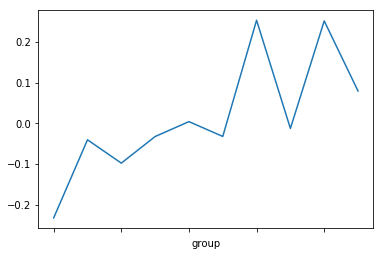

In [254]:
AR=CAPM['alpha']/CAPM['std_e']
AR.plot()
#as signal level goes up, the appraisal ratio has a trend to go up

In [269]:
#next we use FF3 model to evaluate the model
FF3=pd.DataFrame(Wret.mean())
FF3.columns=['Avgreturns']

In [270]:
FF3=pd.DataFrame([],index=FF3.index,\
                 columns=['alpha','talpha','betamkt','tbetamkt','betahml','tbetahml','betasmb','tbetasmb']) 
# create dataframe to store residual
FF3Resid=Wret.copy()
#store avg return
#FF3['avg']=Data.drop(['MKT','HML','SMB'],axis=1).mean()

for portfolio in FF3.index:
    y=Wret[portfolio]
    x=factor[['Mkt-RF','HML','SMB']]
    x=sm.add_constant(x)
    results = sm.OLS(y,x).fit()
    FF3.at[portfolio,['alpha','betamkt','betahml','betasmb']]=results.params.values
    FF3.at[portfolio,['talpha','tbetamkt','tbetahml','tbetasmb']]=(results.params/results.HC0_se).values
    FF3Resid[portfolio]=results.resid
FF3=FF3.astype('float')   
FF3
#tbetamkt reject null hypothesis betamkt=0,while tbetahml,tbetasmb can not.

,alpha,talpha,betamkt,tbetamkt,betahml,tbetahml,betasmb,tbetasmb
group,,,,,,,,
hurst0,-0.008465,-1.464633,0.842425,4.640610,0.417850,1.370634,-0.291741,-1.084680
hurst1,0.000278,0.054622,0.948195,6.188695,0.658896,3.122249,-0.057539,-0.288089
hurst2,-0.002591,-0.423634,1.181454,5.404907,0.386522,1.428455,0.181676,0.951400
hurst3,0.000286,0.057204,0.749961,3.914251,0.496265,1.749969,0.222532,1.026459
hurst4,-0.000478,-0.115058,0.703092,3.294981,-0.159284,-0.723927,-0.185082,-1.135441
hurst5,-0.001065,-0.367556,0.739009,5.129000,-0.093948,-0.520913,-0.083165,-0.640352
hurst6,0.005511,1.435504,0.642005,4.560925,-0.328449,-2.119566,-0.042974,-0.373777
hurst7,-0.000825,-0.202812,0.451653,2.194815,-0.141501,-0.863085,-0.067769,-0.450771
hurst8,0.010792,1.859682,0.846537,5.060752,0.434584,1.263374,0.095711,0.475686


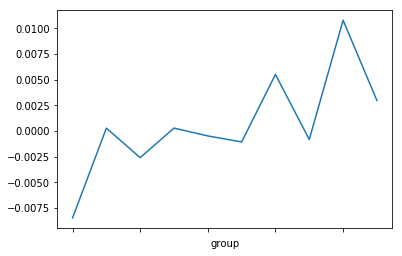

In [257]:
FF3.alpha.plot()
#talpha still can not reject null hypothesis at 95% level

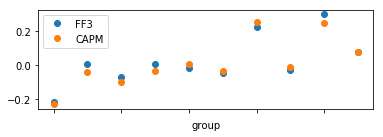

In [258]:
fig = plt.figure()
ax1 = plt.subplot(2,1,1)
(FF3.alpha/FF3Resid.std()).plot(ax=ax1,style='o')
(CAPM.alpha/CAPM['std_e']).plot(ax=ax1,style='o')

plt.legend(['FF3','CAPM'])#FF3 alpha is not significantly reduced.

In [259]:
#Implement analysis
#hurst signal used past returns trend to construct different portfolios like momentum, 
#so we also need to consider the trading risk of the strategy
Vol = pd.read_csv("D:\SIMON\QUANT FIN PYTHON\Final Project\dataset\Volume.csv",index_col=0, \
                         parse_dates=True,header=0,na_values=-99.99)
Vol=Vol['2013-06':'2018-06']
Vol

,DTE,PPL,XEL,D,ETR,NEE,DUK,SO,AVA,PCG,...,CAG,C,F,HOG,JNJ,KMB,KO,PFE,SNE,TM
Date,,,,,,,,,,,,,,,,,,,,,
2013-06-01,25013900.0,87671600,105260600.0,77562600.0,23865300.0,44735700.0,65130300.0,97161700.0,7073100.0,70324400.0,...,75370300.0,570461800.0,8.571037e+08,29401900.0,200315600.0,37375000.0,260921100.0,7.658479e+08,45988300.0,13879300.0
2013-07-01,18509600.0,98029200,54007900.0,45608200.0,36972400.0,41525800.0,52162000.0,108130200.0,5158900.0,59240000.0,...,66114800.0,470388900.0,7.384527e+08,26784600.0,204260800.0,32898300.0,296801300.0,5.128230e+08,49440100.0,9083500.0
2013-08-01,16744100.0,230359900,61896700.0,64278700.0,35098100.0,35327200.0,74398200.0,81966200.0,5270500.0,50040400.0,...,164869700.0,469357000.0,7.713366e+08,20821500.0,158876500.0,28496900.0,300960000.0,5.082147e+08,43853400.0,8360300.0
2013-09-01,25923800.0,128284600,100306600.0,62634100.0,23167600.0,45962100.0,56848600.0,87707700.0,5333000.0,73975400.0,...,102097700.0,548937600.0,8.606335e+08,28940800.0,173024000.0,41892900.0,378979000.0,6.224678e+08,61014300.0,6721300.0
2013-10-01,25466800.0,117126600,61552900.0,46715200.0,28762000.0,37956300.0,58630600.0,146238700.0,5182600.0,52644900.0,...,77955700.0,427626200.0,6.723924e+08,21278500.0,131026200.0,40152600.0,267950200.0,4.622504e+08,75161900.0,7704200.0
2013-11-01,20983300.0,101771700,65436600.0,69247800.0,24561200.0,41368800.0,75366600.0,110535400.0,6504800.0,57669500.0,...,81652100.0,402157100.0,1.037390e+09,20978400.0,151086000.0,34119700.0,301144500.0,5.281491e+08,39312400.0,8001200.0
2013-12-01,23212600.0,95873300,87079500.0,42672500.0,30862100.0,45446200.0,54472000.0,108626800.0,6733400.0,60967400.0,...,72100500.0,674576100.0,1.003488e+09,27561000.0,192804300.0,43495400.0,289400900.0,5.472696e+08,69318700.0,8815500.0
2014-01-01,22511400.0,82723900,61821800.0,51101800.0,36653200.0,46336400.0,70414700.0,106401400.0,7359900.0,58763300.0,...,127297500.0,506390800.0,7.126964e+08,27328400.0,162234700.0,35125500.0,385231900.0,5.330566e+08,60366300.0,9045900.0
2014-02-01,24819100.0,89912800,44013600.0,46663000.0,33476200.0,40038700.0,60207800.0,72270000.0,5975100.0,51480200.0,...,98328100.0,663022400.0,6.173546e+08,23313300.0,181324400.0,37082700.0,349073700.0,5.713000e+08,48979200.0,7753200.0


In [260]:
Vol = pd.read_csv("D:\SIMON\QUANT FIN PYTHON\Final Project\dataset\Volume.csv",index_col=0, \
                         parse_dates=True,header=0,na_values=-99.99)
Vol=Vol['2013-06':'2018-06']
Vol
VolT = Vol.T
VolN = VolT.unstack(level = 1)
VolN = pd.DataFrame(VolN)
VolN.to_csv('D:\\SIMON\\QUANT FIN PYTHON\\Final Project\\vol.csv')
Vol=pd.read_csv('D:\\SIMON\\QUANT FIN PYTHON\\Final Project\\vol.csv',index_col=0)
Vol.columns=['Stock','Volume']
Vol=Vol['2014-05':]

In [272]:
port_vwret = data1.groupby(['Date','group']).apply(wavg, 'ret','weight')
port_vwret = port_vwret.reset_index().rename(columns={0:'port_ret'})   
# merge back and assing to each stock the return on the portfolio that it belongs at date t
voldata=data1.merge(port_vwret,how='left',on=['Date','group'])
voldata['group_lead']=voldata.groupby('Stock').group.shift(-1)
voldata['weight_lead']=voldata.groupby('Stock').weight.shift(-1)

In [273]:
voldata['trade']=voldata.weight_lead*(voldata.group==voldata.group_lead)-voldata.weight*(1+voldata.ret)/(1+voldata.port_ret)

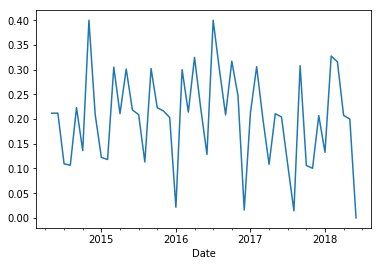

In [274]:
voldata.groupby(['Date','group']).trade.apply(lambda x:x.abs().sum()).loc[:,'hurst9'].plot()
#the plot shows considerate volatility across time

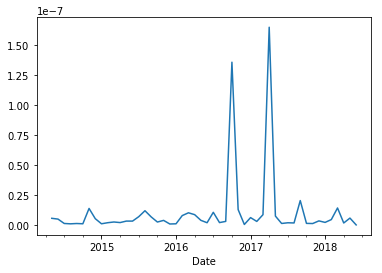

In [265]:
Vol=Vol.reset_index()
voldata['volume']=Vol['Volume']
voldata['tradepervol']=voldata.trade/voldata.volume
voldata.groupby(['Date','group']).tradepervol.apply(lambda x:x.abs().sum()).loc[:,'hurst9'].plot()

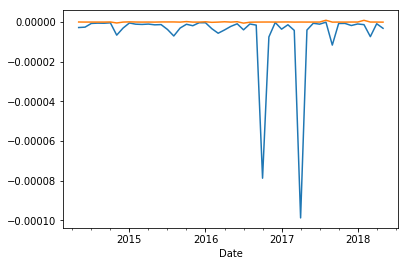

In [266]:
Position=1e3 #(1e3 means one billion dollars)
threshold=0.10
(Position*(voldata.groupby(['Date','group']).tradepervol.quantile(threshold).loc[:,'hurst9'])).plot()
(Position*(voldata.groupby(['Date','group']).tradepervol.quantile(1-threshold).loc[:,'hurst9'])).plot()